Importing libraries to use their methods.

torch, torch.nn: for building and training CNN.

torch.optim: for optimizers for CNN models.

torchvision.transforms: for image preprocessing (converts images to tensors).

torchvision: This is where the CIFAR-10 dataset is stored.

fastai.data.external: for downloading and loading dataset.

torch.utils.data: to efficiently load data with data loaders.

matplotlib: for plotting graphs.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from fastai.data.external import untar_data, URLs
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Cuda to help with gpu speed

Using the fastai's builtin method to call and download the CIFAR10 dataset.

After being called the file is stored as path object, as we will be working with files inside files, we need the main path to be a string as later we can add specific file path to it.

In [ ]:
data = untar_data(URLs.CIFAR)
data = str(data)

transforms helps converts images to tensors which are easier for pytorch to understand as it scale the range to 0 to 1.

And by normalizing the dataset, we scale the image from -1 to 1.


In [ ]:
# Data transformations (normalize CIFAR images)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

in trainset we use the str data path to the train file and transform images to tensors and add label to them.

train_loader is a dataset created using the imagefolder training set. batch size = loads 128 images per batch. shuffle helps with randomized order when choosing images during each epoch.

In [ ]:
# Load training data using ImageFolder (reads directly from class folders)
trainset = ImageFolder(root=f'{data}/train', transform=transform)
train_loader = DataLoader(trainset, batch_size=128, shuffle=True)

The structure and architecture for the 4 layer CNN model. Implemented a model that uses 4 layers with batch normalization and max pooling applied to the first 2 layers inspired from the alexnet model.

In [ ]:
# Basic 4-layer CNN with Batch Normalization (based on https://github.com/kuangliu/pytorch-cifar)
class FourLayerCNN(nn.Module):
    def __init__(self, activation_function='relu'):
        super(FourLayerCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # conv1 - input has 3 channels (RGB), output has 32 channels, with kernel size of 3x3 and a padding of 1
        self.bn1 = nn.BatchNorm2d(32)  # BatchNorm after conv1
        # conv2 with 32 channels to 64 channels output
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # BatchNorm after conv2
        #conv3 with 64 channels to 128 channels output
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        #conv4 - no change in ouput just added layer to improve model learning and increase accuracy.
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        #Max pooling is done to downsize the images from its imput size to output size by choosing the max value.
        self.pool = nn.MaxPool2d(2, 2)
        # the max pooling layers reduce the input 32 x 32 to 16 x 16 to 8 x 8 and the 128 is the final number of channels.
        self.fc = nn.Linear(128 * 8 * 8, 10) # 10 is the 10 classes of the CIFAR-10 dataset

        # For each activation function
        if activation_function == "relu":
            self.activation = nn.ReLU()
        elif activation_function == "tanh":
            self.activation = nn.Tanh()
        elif activation_function == "sigmoid":
            self.activation = nn.Sigmoid()

# The construction of the model
    def forward(self, x):
        #layer with pooling and activation
        x = self.pool(self.activation(self.bn1(self.conv1(x))))
        #layer with pooling and activation
        x = self.pool(self.activation(self.bn2(self.conv2(x))))
        #layer with activation
        x = self.activation(self.conv3(x))
        #layer with activation
        x = self.activation(self.conv4(x))
        # flatten to flatten the feature map for fully connected layers
        x = x.flatten(1)
        # the fully connected layer
        x = self.fc(x)
        return x

Training metrics calculated for the model.

In [ ]:
# List of parameters to take note of for plotting graph
train_losses = []
train_accuracies = []
train_errors = []
epochs_list = []

def train_cnn(activation_function='relu'):
    # global to store the data
    global train_losses, train_accuracies, train_errors, epochs_list

    # resetting the lists for every activation function
    train_losses = []
    train_accuracies = []
    train_errors = []
    epochs_list = []

    # call the model and pass the activation function chosen
    model = FourLayerCNN(activation_function=activation_function).to(device)
    # utilizing optimizer Adam to make model converge better and faster
    optimizer = optim.Adam(model.parameters(), lr=0.001) # learning rate of 0.001 seemed optimal
    criterion = nn.CrossEntropyLoss() # cross entropy as the dataset is a multiclass dataset (classification task)

    for epoch in range(100):  # Max 100 epochs, but stops if training error <= 25% as stated in the prompt
        running_loss = 0.0 # to find the sum and average loss faced by the model
        correct = 0 # for correctly classfied images
        total = 0 # total samples taken

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad() # resets the GD back to 0
            outputs = model(inputs) # forward propagation - input to output
            loss = criterion(outputs, labels)  # predicted versus actual label
            loss.backward() # backward propagation - output to input
            optimizer.step() # update model

            running_loss += loss.item() # sum the loss to find average later

            _, predicted = outputs.max(1) # majority rules = take the prediction of the majority
            total += labels.size(0) # count samples computed
            correct += (predicted == labels).sum().item() # count the correct predictions made by the model

        train_error = 1 - (correct / total) # training error formula
        train_accuracy = 100 * correct / total # training accuracy formula

        # append into the list for visualization later
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)
        train_errors.append(train_error * 100)
        epochs_list.append(epoch + 1)

        # printing details for each epoch when model runs
        print(f"Epoch {epoch+1}: Loss = {running_loss:.3f}, Training error = {train_error:.2%}")

        # The early stopping condition given by the prompt
        if train_error <= 0.25:
            print("Training error reached the 25% threshold, model stopping...")
            print(f"Training accuracy: {train_accuracy}%\n")
            break

Visualization

In [ ]:
# Plot function
def plot_results(activation_function):
    plt.figure(figsize=(15, 5))

    # Training Error
    plt.subplot(1, 2, 1)
    plt.plot(epochs_list, train_errors, label=activation_function)
    plt.title('Training Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error (%)')
    plt.legend()
    plt.grid(True)

    # Training Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_list, train_accuracies, label=activation_function)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Looping for each activation function.


Model 1: Using relu activation function:
Epoch 1: Loss = 507.426, Training error = 46.87%
Epoch 2: Loss = 349.843, Training error = 31.79%
Epoch 3: Loss = 281.685, Training error = 25.13%
Epoch 4: Loss = 232.363, Training error = 20.78%
Training error reached the 25% threshold, model stopping...
Training accuracy: 79.216%



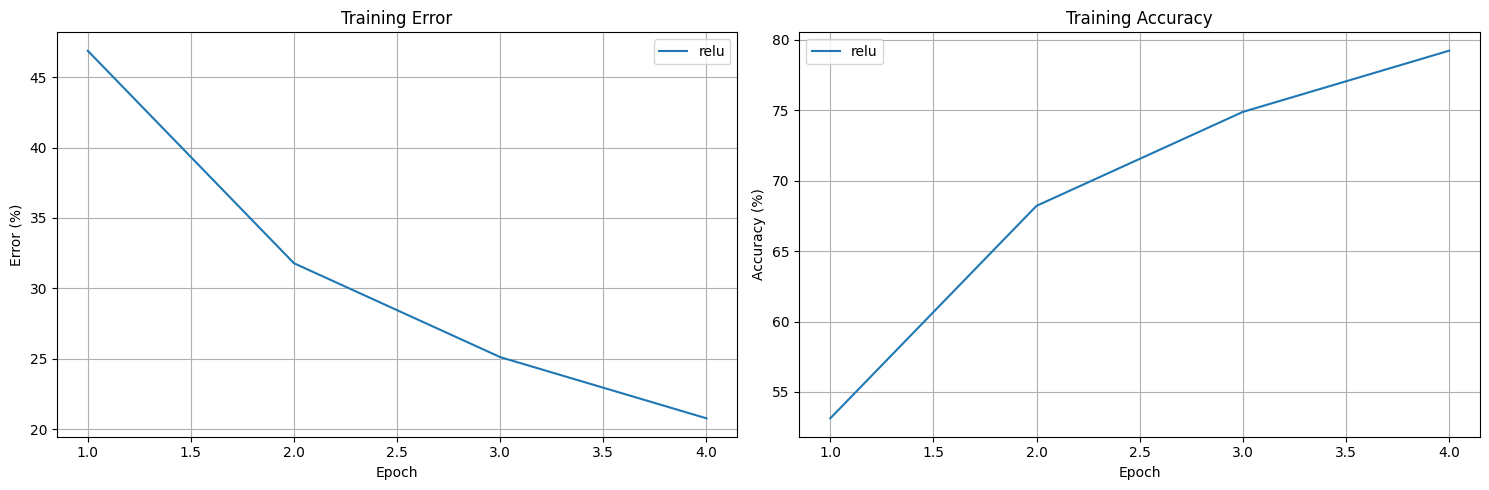


Model 2: Using tanh activation function:
Epoch 1: Loss = 537.956, Training error = 48.58%
Epoch 2: Loss = 429.594, Training error = 38.53%
Epoch 3: Loss = 392.382, Training error = 35.22%
Epoch 4: Loss = 366.309, Training error = 32.60%
Epoch 5: Loss = 344.735, Training error = 30.68%
Epoch 6: Loss = 328.567, Training error = 29.24%
Epoch 7: Loss = 313.831, Training error = 27.80%
Epoch 8: Loss = 296.374, Training error = 26.25%
Epoch 9: Loss = 280.965, Training error = 24.99%
Training error reached the 25% threshold, model stopping...
Training accuracy: 75.008%



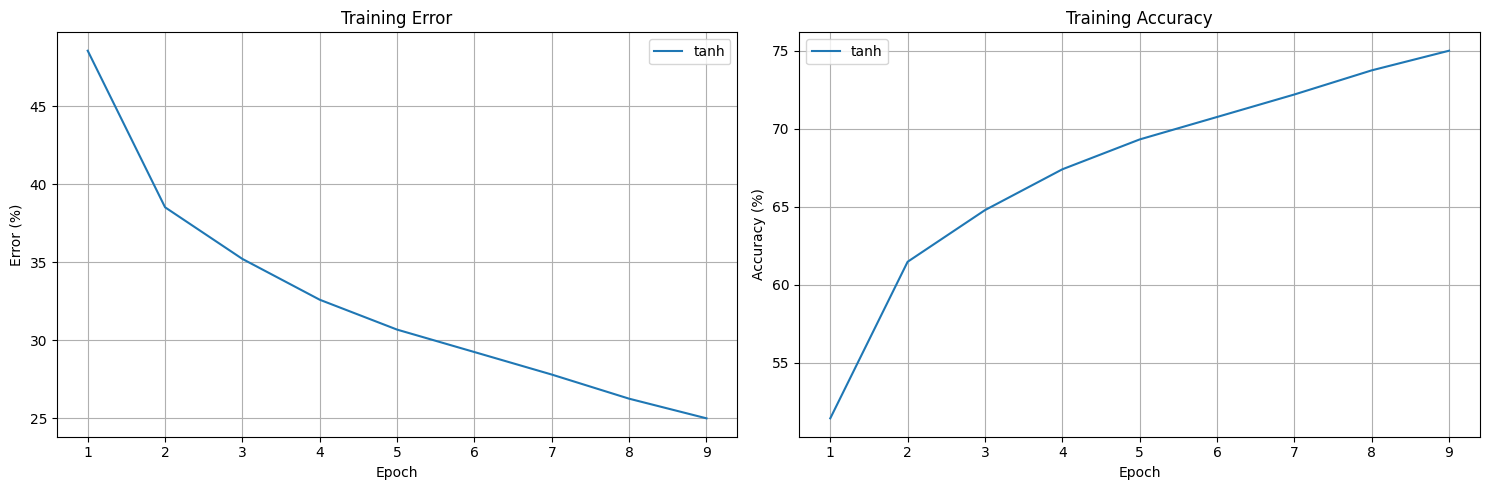


Model 3: Using sigmoid activation function:
Epoch 1: Loss = 841.264, Training error = 82.61%
Epoch 2: Loss = 616.057, Training error = 58.01%
Epoch 3: Loss = 546.126, Training error = 50.70%
Epoch 4: Loss = 495.006, Training error = 45.43%
Epoch 5: Loss = 460.841, Training error = 41.87%
Epoch 6: Loss = 431.353, Training error = 39.15%
Epoch 7: Loss = 402.717, Training error = 36.25%
Epoch 8: Loss = 380.939, Training error = 34.16%
Epoch 9: Loss = 363.256, Training error = 32.69%
Epoch 10: Loss = 344.020, Training error = 30.95%
Epoch 11: Loss = 327.427, Training error = 29.40%
Epoch 12: Loss = 313.277, Training error = 27.99%
Epoch 13: Loss = 297.463, Training error = 26.78%
Epoch 14: Loss = 281.182, Training error = 25.13%
Epoch 15: Loss = 266.356, Training error = 23.79%
Training error reached the 25% threshold, model stopping...
Training accuracy: 76.212%



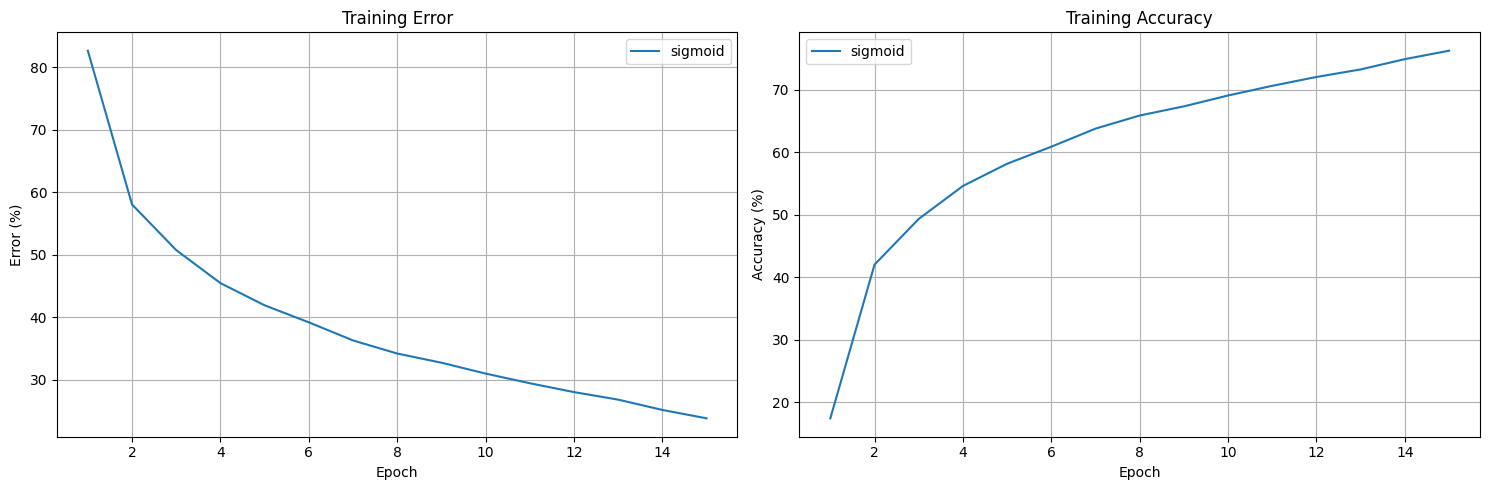

In [ ]:
i=1
# Train and plot for each activation function
for activation in ["relu", "tanh", "sigmoid"]:
    print(f"\nModel {i}: Using {activation} activation function:")
    train_cnn(activation_function=activation)
    plot_results(activation)
    i+=1

From the graphs and the metrics for each activation function:

ReLU:

Converges faster, reaching the 25% mark in just 4 epochs, training increased consistently reaching 79.22% being the best out of all other models.
Running the model with no early stopping might give better results.

TanH:

Convergence was at a medium pace reaching the 25% error mark by the 9th epoch with its training accuracy stopped at 75.01%. The model is learning gradually but is slower than ReLU.

Sigmoid:

Convergence is slow compared to the other two reachong the 25% error mark only by the 15th epoch with the final training accuracy at 76.21%.

References:

[1] https://github.com/kuangliu/pytorch-cifar